In [ ]:
# install dependencies

!pip install pydub
!pip install praat-parselmouth
!pip install nemo_toolkit['all']
!pip install git+https://github.com/NVIDIA/NeMo.git
!pip install nltk
!wget https://raw.githubusercontent.com/NVIDIA/NeMo/v1.12.0/scripts/tts_dataset_files/cmudict-0.7b_nv22.08

In [ ]:
# import dependencies
import glob
import itertools
import librosa
import nltk
import os
import parselmouth
import pprint
import re
import matplotlib.pylab as plt
import multiprocessing as mp
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from google.colab import files
from IPython.display import Audio, display
from nemo.collections.tts.g2p.models.en_us_arpabet import EnglishG2p
from pydub import AudioSegment
from tqdm import tqdm
from wordcloud import WordCloud
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.probability import FreqDist

# set parameters
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pp = pprint.PrettyPrinter(indent =4, depth=10)
sns.set()
tqdm.pandas()

## Load Data

In [ ]:
# upload dataset

uploaded = files.upload()

Saving cnx1_ds_ss_task.zip to cnx1_ds_ss_task.zip


In [ ]:
# extract dataset
!unzip /content/cnx1_ds_ss_task.zip

In [ ]:
# open metadata file and extract data
with open('cnx1_ds_ss_task/metadata.csv', 'r', encoding='utf-8') as f:
    id_transcript = [line.strip().split('|') for line in f]

In [ ]:
# load metadata into dataframe
df = pd.DataFrame(id_transcript, columns = ['Id', 'Transcript'])
df

,Id,Transcript
0,jane_eyre_01_f000001,Chapter 1 of Jane eyre. This is there librivox...
1,jane_eyre_01_f000002,Recording by Elisabeth Klett.
2,jane_eyre_01_f000003,Jane eyre by Charlotte Bronte. Chapter 1.
3,jane_eyre_01_f000004,There was no possibility of taking a walk that...
4,jane_eyre_01_f000005,"We had been wandering, indeed, in the leafless..."
...,...,...
2970,jane_eyre_14_f000260,Not valuing now the root whence it sprang; hav...
2971,jane_eyre_14_f000261,especially when it looks so artificial as just...
2972,jane_eyre_14_f000262,I keep it and rear it rather on the Roman Cath...
2973,jane_eyre_14_f000263,Good-night.


In [ ]:
# load audio file paths into list object
audio_id_full = glob.glob('cnx1_ds_ss_task/wavs/*.wav')
audio_id_full

## Check Correspondence

In [ ]:
# get utterrance id from audio path
audio_id = [os.path.basename(x)[:-4] for x in audio_id_full]
audio_id

In [ ]:
# check audio utterance id against metadata id to find any missing audio
df['id_check'] = df['Id'].isin(audio_id)
df = df[df.id_check]
df = df.drop(columns=['id_check'])
df

,Id,Transcript
0,jane_eyre_01_f000001,Chapter 1 of Jane eyre. This is there librivox...
1,jane_eyre_01_f000002,Recording by Elisabeth Klett.
2,jane_eyre_01_f000003,Jane eyre by Charlotte Bronte. Chapter 1.
3,jane_eyre_01_f000004,There was no possibility of taking a walk that...
4,jane_eyre_01_f000005,"We had been wandering, indeed, in the leafless..."
...,...,...
2970,jane_eyre_14_f000260,Not valuing now the root whence it sprang; hav...
2971,jane_eyre_14_f000261,especially when it looks so artificial as just...
2972,jane_eyre_14_f000262,I keep it and rear it rather on the Roman Cath...
2973,jane_eyre_14_f000263,Good-night.


## Analyse audio

Identify audio anomalies by extracting feature values and checking files with outliers. The feature values can also inform us about the quality and expressiveness of the voice and the consistency of these features.

In [ ]:
# check for empty audio or audio with the wring sample rate
for path in audio_id_full:

    # check for empty files
    dur = librosa.get_duration(path=path)
    if dur < 1:
        print('Empyty file:', path, dur)

    # check for mimatched sample rate
    sr = librosa.get_samplerate(path)
    if sr != 8000:
        print('Incorrect sample rate:', path, sr)

In [ ]:
# function to extract acoustic features from audio
def process_audio(f_path):

    id = os.path.basename(f_path)[:-4]

    audio_segment = AudioSegment.from_file(f_path)
    y, sr = librosa.load(f_path)
    sound = parselmouth.Sound(f_path)

    # durations
    dur = librosa.get_duration(y=y, sr=sr)
    # amplitude
    peak_amplitude = audio_segment.max
    # intensity
    intensity = audio_segment.dBFS
    # rms
    rms = audio_segment.rms
    # spectral centroid
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
    # spectral bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)

    audio_obj = {
        "id": id,
        "duration": dur,
        "peak amplitude": peak_amplitude,
        "rms": rms,
        "intensity": intensity,
        "centroids mean": np.mean(spectral_centroids),
        "centroids std": np.std(spectral_centroids),
        "bandwidth mean": np.mean(spectral_bandwidth),
        "bandwidth std": np.std(spectral_bandwidth)
    }
    try:
        # pitch
        pitch = sound.to_pitch()
        # f0
        f0 = pitch.selected_array['frequency']
        pulses = parselmouth.praat.call([sound, pitch], "To PointProcess (cc)")
        voice_report_str = \
            parselmouth.praat.call([sound, pitch, pulses], "Voice report", 0.0, 0.0, 75, 600, 1.3, 1.6, 0.03, 0.45)
        report_list = voice_report_str.split('\n')
        report_list = [e.strip() for e in report_list if ': ' in e]
        for line in report_list[1:]:
            if line:
                line_list = line.split(': ')
                audio_obj[line_list[0]] = line_list[1]
    except:
        f0 = 0
    audio_obj["f0 mean"] = np.mean(f0)
    audio_obj["f0 std"] = np.std(f0)
    return audio_obj

In [ ]:
# multiprocessing function calling
audio_meta_list = []

with mp.Pool(mp.cpu_count()) as pool:
    results = tqdm(
        pool.imap_unordered(process_audio, audio_id_full, chunksize=10),
        total=len(audio_id_full),
    )

    for result in results:
        if result:
            audio_meta_list.append(result)

100%|██████████| 2975/2975 [01:02<00:00, 47.76it/s]


In [ ]:
# reformat and clean feature table

audio_meta = pd.DataFrame(audio_meta_list)
audio_meta.rename(columns={'Median pitch': 'Median pitch (Hz)', 'Mean pitch': 'Mean pitch (Hz)', 'Standard deviation': 'Std pitch (Hz)', 'Minimum pitch': 'Minimum pitch (Hz)', 'Maximum pitch': 'Maximum pitch (Hz)'}, inplace=True)
audio_meta.rename(columns={'Mean period': 'Mean period (secs)', 'Standard deviation of period': 'Std period (secs)', 'Jitter (local, absolute)': 'Jitter (local, absolute, secs)', 'Degree of voice breaks': 'Degree of voice breaks (secs/secs)'}, inplace=True)
audio_meta.rename(columns={'Fraction of locally unvoiced frames': 'Fraction of locally unvoiced frames (%)', 'Jitter (local)': 'Jitter (local, %)', 'Jitter (rap)': 'Jitter (rap, %)', 'Jitter (ppq5)': 'Jitter (ppq5, %)', 'Jitter (ddp)': 'Jitter (ddp, %)', 'Shimmer (local)': 'Shimmer (local, %)', 'Shimmer (apq3)': 'Shimmer (apq3, %)', 'Shimmer (apq5)': 'Shimmer (apq5, %)', 'Shimmer (apq11)': 'Shimmer (apq11, %)', 'Shimmer (dda)': 'Shimmer (dda, %)'}, inplace=True)
audio_meta.rename(columns={'Mean harmonics-to-noise ratio': 'Mean harmonics-to-noise ratio (dB)'}, inplace=True)

audio_meta.replace('^.*undefined.*$', np.nan, regex=True, inplace=True)
audio_meta.replace([np.inf, -np.inf], np.nan, inplace=True)
audio_meta.replace(' Hz', '', regex=True, inplace=True)
audio_meta.replace(' seconds', '', regex=True, inplace=True)
audio_meta.replace('%', '', regex=True, inplace=True)
audio_meta.replace(' dB', '', regex=True, inplace=True)
audio_meta.replace(' \(\d+ / \d+\)', '', regex=True, inplace=True)
audio_meta.replace('E-(?=\d)', 'e-', regex=True, inplace=True)
audio_meta.replace(0, np.nan, inplace=True)
cols = audio_meta.columns.drop(['id'])
audio_meta[cols] = audio_meta[cols].apply(pd.to_numeric, errors='coerce')
df_audio = audio_meta.copy()
df_audio

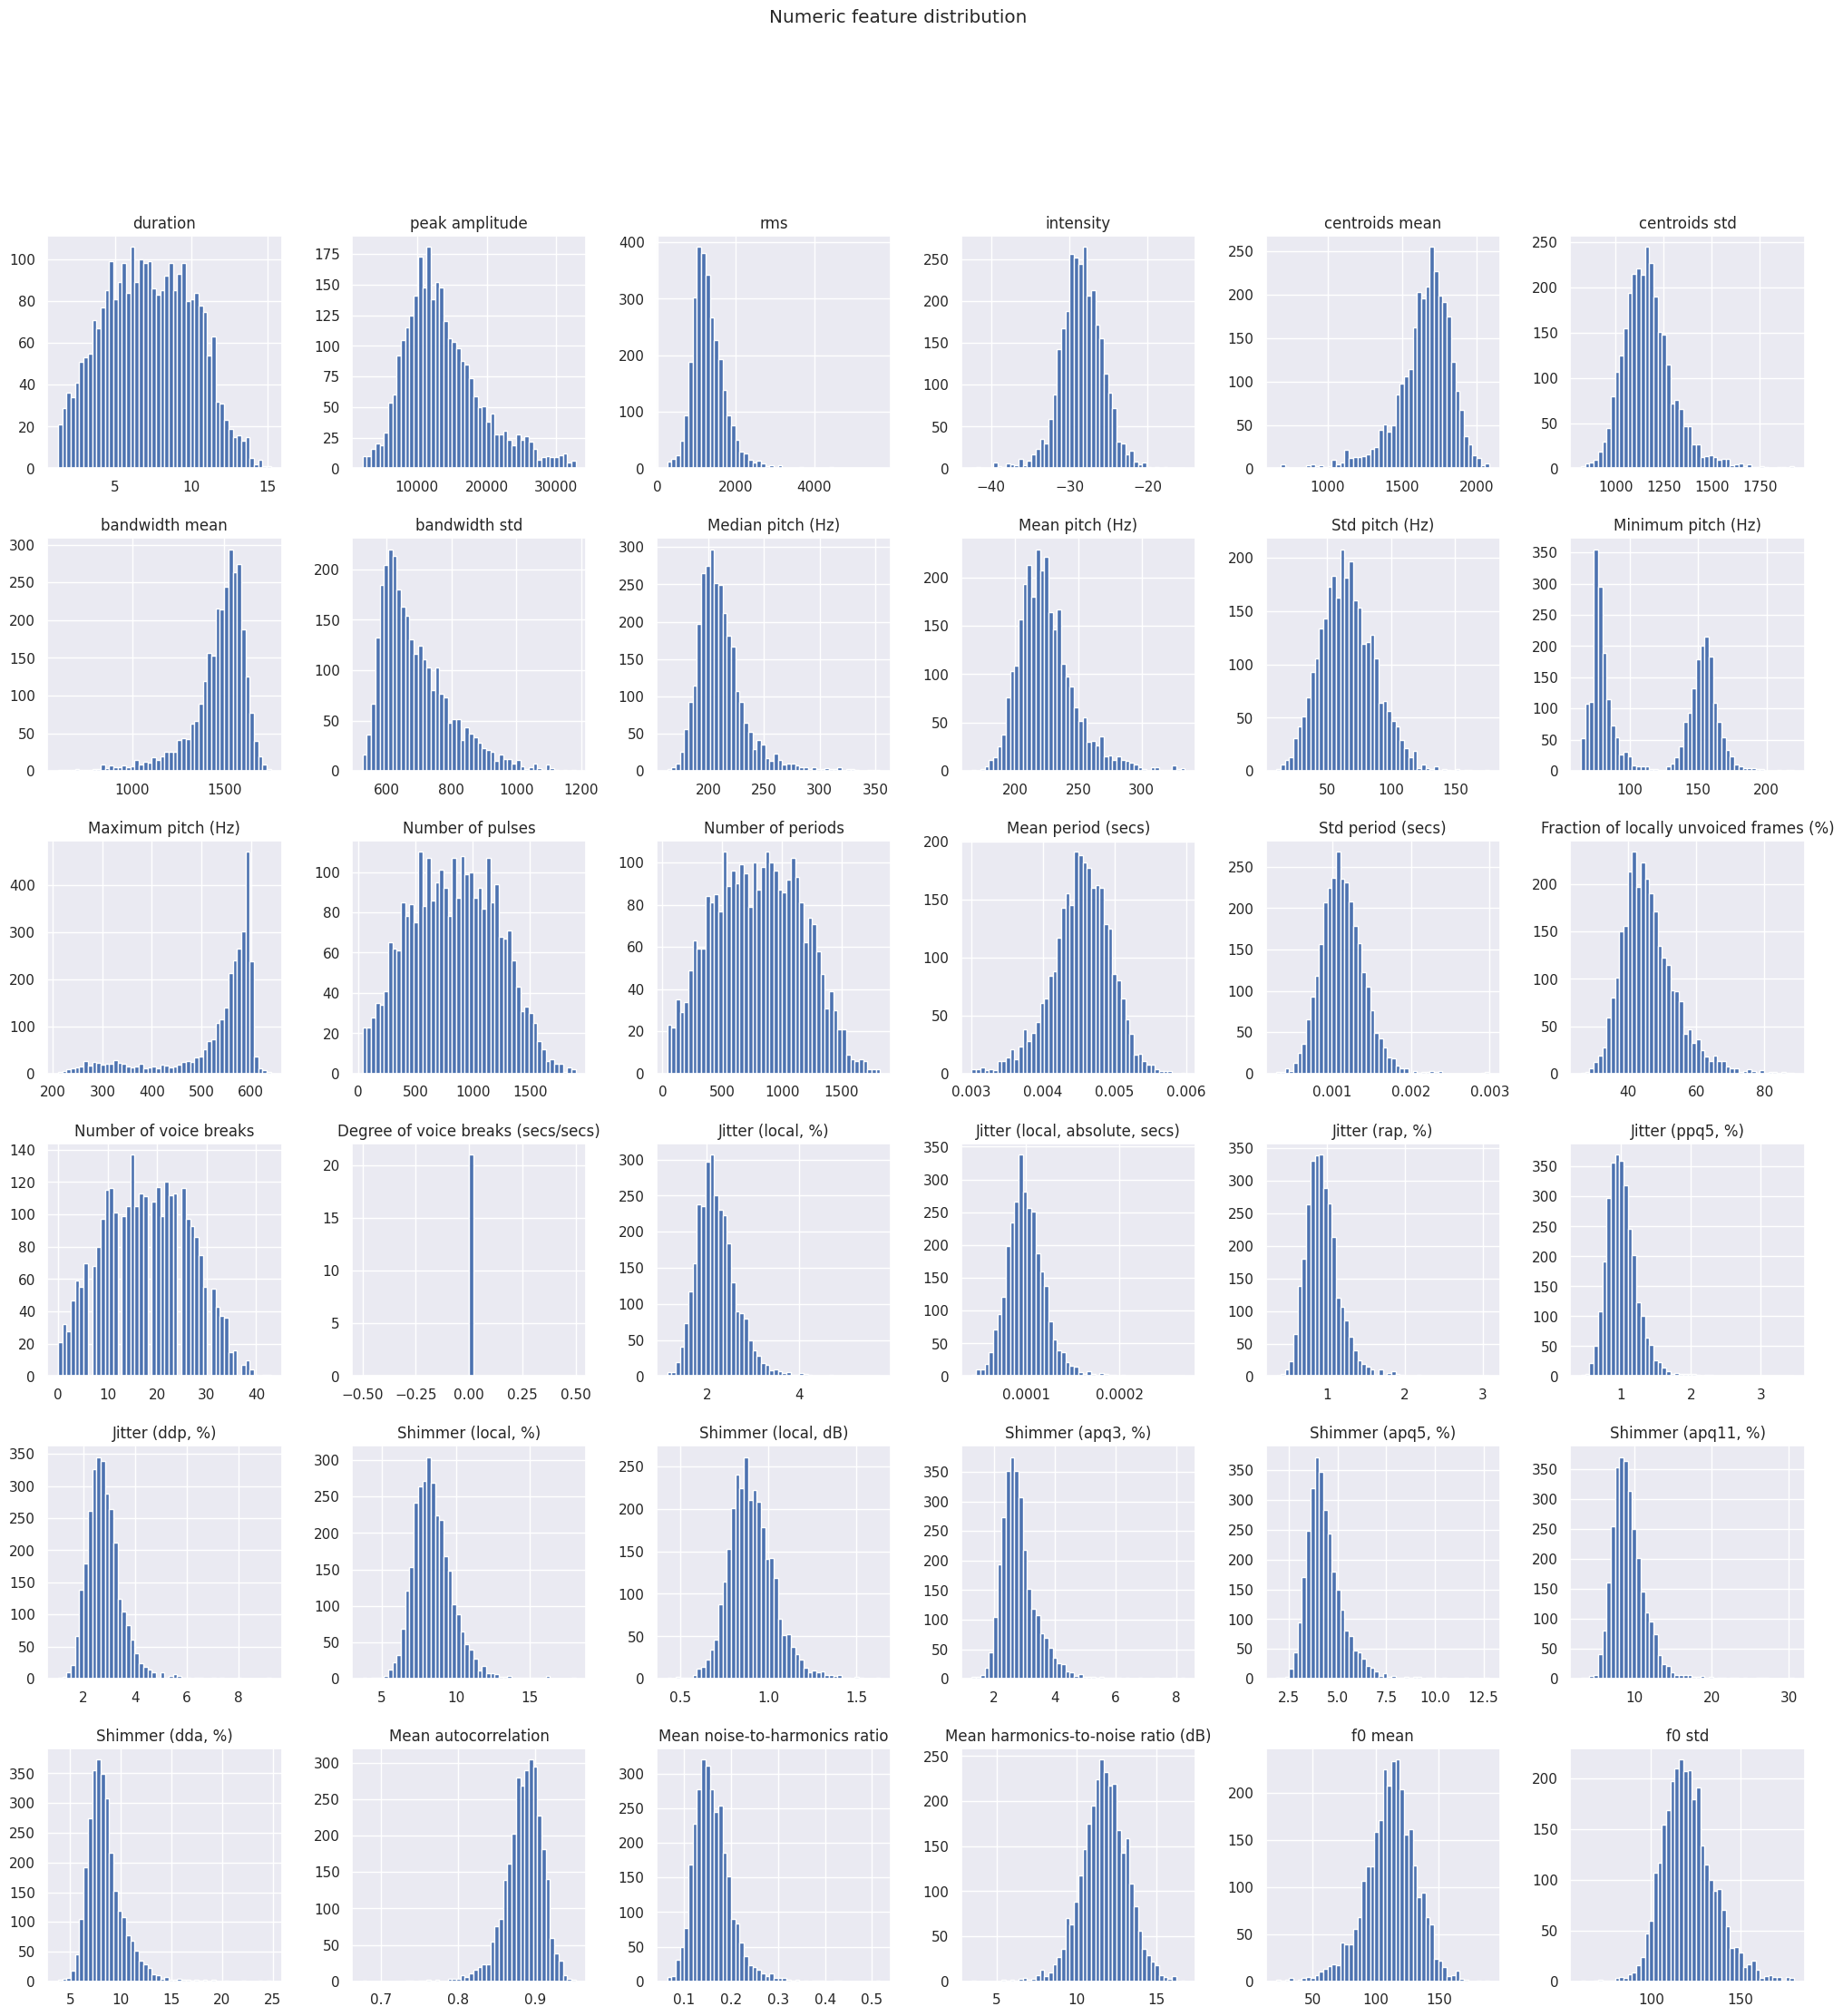

In [ ]:
# plot feature values for quick check for outliers of distribution
df_audio_plot = df_audio.drop(columns=['id'])
df_audio_plot.hist(figsize=[25,25], bins=50)
plt.suptitle("Numeric feature distribution")
plt.show()

In [ ]:
# derive feature value ranges to better identify outliers
df_audio.describe()

,duration,peak amplitude,rms,intensity,centroids mean,centroids std,bandwidth mean,bandwidth std,Median pitch (Hz),Mean pitch (Hz),Std pitch (Hz),Minimum pitch (Hz),Maximum pitch (Hz),Number of pulses,Number of periods,Mean period (secs),Std period (secs),Fraction of locally unvoiced frames (%),Number of voice breaks,Degree of voice breaks (secs/secs),"Jitter (local, %)","Jitter (local, absolute, secs)","Jitter (rap, %)","Jitter (ppq5, %)","Jitter (ddp, %)","Shimmer (local, %)","Shimmer (local, dB)","Shimmer (apq3, %)","Shimmer (apq5, %)","Shimmer (apq11, %)","Shimmer (dda, %)",Mean autocorrelation,Mean noise-to-harmonics ratio,Mean harmonics-to-noise ratio (dB),f0 mean,f0 std
count,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,21.0,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2974.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000
mean,7.253703,13790.484034,1301.599328,-28.474403,1648.123729,1170.969242,1468.962033,691.012596,211.282052,225.007787,66.118072,117.671083,529.584838,832.940168,801.897815,0.004525,0.001128,46.187458,17.908908,0.0,2.217233,0.000100,0.943631,1.020647,2.830902,8.469153,0.906319,2.825866,4.364079,9.279049,8.477602,0.885280,0.160809,11.708459,111.610933,120.920899
std,2.889463,5599.491488,436.985946,2.837877,190.565734,133.406639,152.667874,106.305533,22.219555,22.476019,21.446926,38.807322,92.642776,376.362802,363.638345,0.000414,0.000277,8.106909,8.625440,0.0,0.452625,0.000021,0.227775,0.229915,0.683339,1.403082,0.130448,0.617180,1.005882,2.275162,1.851533,0.024516,0.040190,1.451135,20.441737,14.629964
min,1.259819,2200.000000,246.000000,-42.490297,654.676696,820.156606,595.299140,526.351147,162.952000,165.847000,10.354000,64.338000,210.376000,40.000000,39.000000,0.003003,0.000288,26.182000,0.000000,0.0,1.142000,0.000042,0.345000,0.429000,1.034000,3.699000,0.426000,1.271000,1.854000,3.071000,3.814000,0.676064,0.064640,3.438000,21.271929,60.680867
25%,4.969841,9905.500000,1024.000000,-30.103000,1563.832314,1082.737978,1414.058931,611.232958,197.037000,209.774500,50.997500,77.906000,519.560500,540.000000,518.000000,0.004283,0.000941,40.700000,11.000000,0.0,1.917500,0.000087,0.794500,0.870000,2.383500,7.533000,0.818500,2.428000,3.725000,7.798750,7.283500,0.872141,0.134222,10.831500,100.026488,111.116847
50%,7.198821,12814.000000,1236.000000,-28.468629,1677.698774,1159.058860,1505.207639,663.019122,207.172000,221.713000,64.670000,131.348000,566.471000,835.000000,802.000000,0.004546,0.001108,44.954000,18.000000,0.0,2.151000,0.000098,0.914000,0.993000,2.741000,8.290000,0.894000,2.712000,4.178000,8.902000,8.135000,0.887812,0.155503,11.732000,113.079557,119.653229
75%,9.489841,16748.500000,1517.000000,-26.689287,1773.055100,1240.105757,1569.091953,748.853627,220.236500,235.954000,80.070000,154.718000,589.339000,1122.500000,1082.000000,0.004806,0.001289,50.449000,25.000000,0.0,2.445000,0.000111,1.054000,1.138000,3.161500,9.202000,0.981000,3.080000,4.790000,10.335500,9.240000,0.901570,0.181210,12.654500,124.693113,129.144683
max,15.242857,32768.000000,5685.000000,-15.214389,2088.161437,1927.196274,1755.220283,1182.305029,354.380000,334.159000,176.639000,220.195000,640.465000,1898.000000,1823.000000,0.005977,0.002996,88.636000,43.000000,0.0,5.746000,0.000270,3.085000,3.476000,9.256000,18.097000,1.636000,8.275000,12.804000,30.691000,24.826000,0.952326,0.517273,16.758000,190.130395,180.063221


In [ ]:
df_audio.loc[df_audio['peak amplitude'] == 2200.000000]

,id,duration,peak amplitude,rms,intensity,centroids mean,centroids std,bandwidth mean,bandwidth std,Median pitch (Hz),Mean pitch (Hz),Std pitch (Hz),Minimum pitch (Hz),Maximum pitch (Hz),Number of pulses,Number of periods,Mean period (secs),Std period (secs),Fraction of locally unvoiced frames (%),Number of voice breaks,Degree of voice breaks (secs/secs),"Jitter (local, %)","Jitter (local, absolute, secs)","Jitter (rap, %)","Jitter (ppq5, %)","Jitter (ddp, %)","Shimmer (local, %)","Shimmer (local, dB)","Shimmer (apq3, %)","Shimmer (apq5, %)","Shimmer (apq11, %)","Shimmer (dda, %)",Mean autocorrelation,Mean noise-to-harmonics ratio,Mean harmonics-to-noise ratio (dB),f0 mean,f0 std
869,jane_eyre_14_f000203,1.429841,2200,246,-42.490297,1195.3886,1732.915815,884.003775,1099.677176,170.398,177.069,16.678,159.546,210.376,48,47,0.005655,0.000524,79.137,0,0.0,2.249,0.000127,1.143,1.275,3.43,13.334,1.288,4.307,7.52,15.068,12.92,0.814463,0.240384,6.771,34.394786,70.422269


In [ ]:
# listen to sample
sound_file = 'cnx1_ds_ss_task/wavs/jane_eyre_14_f000203.wav'
display(Audio(sound_file, autoplay=True))

Identifying and removing outliers can ensure poor quality data is not introduced into training. Moreover features such as F0 mean and variance can indicate the expressiveness of the voice. Using these as a baselne, any feature engineered sample can be conmpared to these to check if improvements have been made. Typicall, feature engineering introduces audio degradation, which can be resolved through voice enhancement processing.

## Analyse Text

Check text for features that may impair model quality for specific use case. Including:
- Sentence length
- Vocabulary (including word frequency)
- Sentence construct
- Phoneme in context distribution

Note: The text should also be text normalized.

In [ ]:
transcript_list = df.Transcript.to_list()

In [ ]:
# check for empty to low character count text
for transcript in transcript_list:
    if len(transcript) < 3:
        print(transcript)

In [ ]:
# check unique characters to find any spurious characters or characters not accepted for training
unique_chars = set(''.join(transcript_list))
unique_chars

In [ ]:
# get utterance length
df['transcript_len'] = df.Transcript.apply(lambda x: len(x))
df

,Id,Transcript,transcript_len
0,jane_eyre_01_f000001,Chapter 1 of Jane eyre. This is there librivox...,175
1,jane_eyre_01_f000002,Recording by Elisabeth Klett.,29
2,jane_eyre_01_f000003,Jane eyre by Charlotte Bronte. Chapter 1.,41
3,jane_eyre_01_f000004,There was no possibility of taking a walk that...,51
4,jane_eyre_01_f000005,"We had been wandering, indeed, in the leafless...",80
...,...,...,...
2970,jane_eyre_14_f000260,Not valuing now the root whence it sprang; hav...,160
2971,jane_eyre_14_f000261,especially when it looks so artificial as just...,51
2972,jane_eyre_14_f000262,I keep it and rear it rather on the Roman Cath...,154
2973,jane_eyre_14_f000263,Good-night.,11


In [ ]:
# sentence lenth analysis
df.transcript_len.describe()

count    2975.000000
mean      102.292773
std        45.366749
min         3.000000
25%        66.000000
50%       103.000000
75%       142.000000
max       186.000000
Name: transcript_len, dtype: float64

In [ ]:
# vocabulary and frequency counts
unique_words = re.sub(r'[^a-zéëï0-9 ]', '', ' '.join(transcript_list).lower()).split(' ')
sorted_unique_words = sorted(dict(Counter(unique_words)).items(), key=lambda kv: kv[1])
sorted_unique_words

[('chidings', 1),
 ('humbled', 1),
 ('consciousness', 1),
 ('inferiority', 1),
 ('darlings', 1),
 ('dispensed', 1),
 ('joining', 1),
 ('acquire', 1),
 ('sociable', 1),
 ('childlike', 1),
 ('sprightly', 1),
 ('lighter', 1),
 ('franker', 1),
 ('cavillers', 1),
 ('questioners', 1),
 ('pleasantly', 1),
 ('adjoined', 1),
 ('crosslegged', 1),
 ('turk', 1),
 ('moreen', 1),
 ('shrined', 1),
 ('retirement', 1),
 ('protecting', 1),
 ('stormbeat', 1),
 ('shrub', 1),
 ('lamentable', 1),
 ('blast', 1),
 ('bewicks', 1),
 ('letterpress', 1),
 ('thereof', 1),
 ('cared', 1),
 ('haunts', 1),
 ('seafowl', 1),
 ('promontories', 1),
 ('norway', 1),
 ('studded', 1),
 ('extremity', 1),
 ('lindeness', 1),
 ('naze', 1),
 ('cape', 1),
 ('ocean', 1),
 ('boils', 1),
 ('naked', 1),
 ('farthest', 1),
 ('thule', 1),
 ('atlantic', 1),
 ('surge', 1),
 ('pours', 1),
 ('stormy', 1),
 ('hebrides', 1),
 ('unnoticed', 1),
 ('bleak', 1),
 ('shores', 1),
 ('lapland', 1),
 ('siberia', 1),
 ('spitzbergen', 1),
 ('nova', 1),
 (

In [ ]:
# get vocab size
len(sorted_unique_words)

7232

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


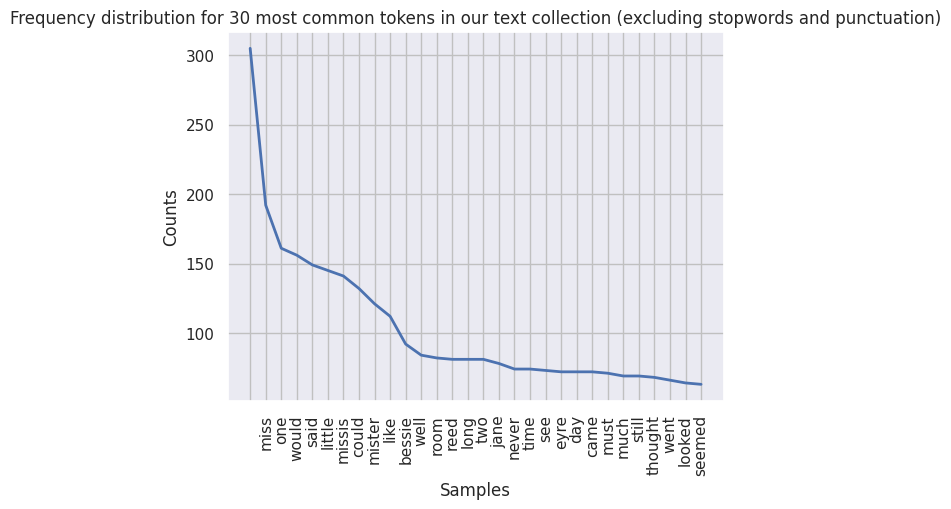

<Axes: title={'center': 'Frequency distribution for 30 most common tokens in our text collection (excluding stopwords and punctuation)'}, xlabel='Samples', ylabel='Counts'>

In [ ]:
# remove stop words (typically high frequency) and plot top 30 frequency words
stop_words = set(stopwords.words('english'))
filtered_text = [w for w in unique_words if not w in stop_words]
fdist_filtered = FreqDist(filtered_text)
fdist_filtered.plot(30,title='Frequency distribution for 30 most common tokens in our text collection (excluding stopwords and punctuation)')

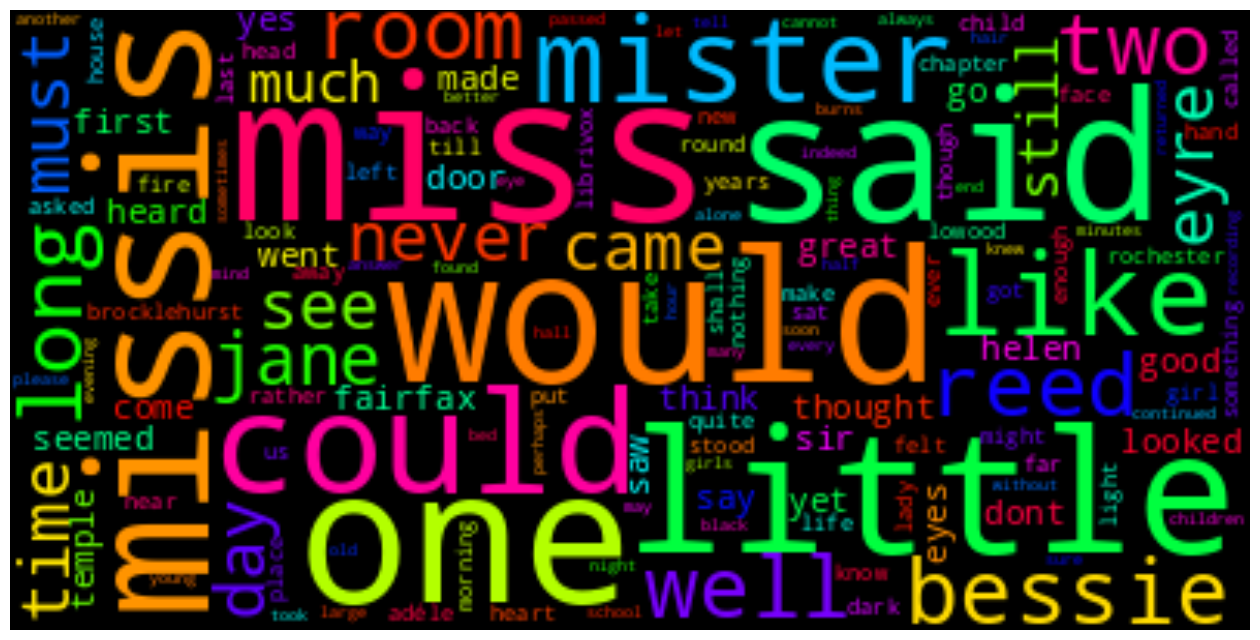

In [ ]:
# plot words cloud of all unique words
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(Counter(filtered_text))
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Check distribution of phonemes in context (triphones)

In [ ]:
# instantiate g2p object and create lexicon
g2p = EnglishG2p(phoneme_dict="cmudict-0.7b_nv22.08", ignore_ambiguous_words=False)
lexicon = {k: v[0] for k, v in g2p.phoneme_dict.items()}
lexicon

In [ ]:
# transcribe utterance
df['phonemes'] = df.Transcript.apply(lambda x: list(itertools.chain.from_iterable([lexicon.get(token.lower()) for token in x.split() if token.lower() in lexicon])))
df

,Id,Transcript,transcript_len,phonemes
0,jane_eyre_01_f000001,Chapter 1 of Jane eyre. This is there librivox...,175,"[CH, AE1, P, T, ER0, AH1, V, JH, EY1, N, DH, I..."
1,jane_eyre_01_f000002,Recording by Elisabeth Klett.,29,"[R, AH0, K, AO1, R, D, IH0, NG, B, AY1, IH0, L..."
2,jane_eyre_01_f000003,Jane eyre by Charlotte Bronte. Chapter 1.,41,"[JH, EY1, N, EH1, R, B, AY1, SH, AA1, R, L, AH..."
3,jane_eyre_01_f000004,There was no possibility of taking a walk that...,51,"[DH, EH1, R, W, AA1, Z, N, OW1, P, AA2, S, AH0..."
4,jane_eyre_01_f000005,"We had been wandering, indeed, in the leafless...",80,"[W, IY1, HH, AE1, D, B, IH1, N, IH0, N, DH, AH..."
...,...,...,...,...
2970,jane_eyre_14_f000260,Not valuing now the root whence it sprang; hav...,160,"[N, AA1, T, V, AE1, L, Y, UW0, IH0, NG, N, AW1..."
2971,jane_eyre_14_f000261,especially when it looks so artificial as just...,51,"[AH0, S, P, EH1, SH, L, IY0, W, EH1, N, IH1, T..."
2972,jane_eyre_14_f000262,I keep it and rear it rather on the Roman Cath...,154,"[AY1, K, IY1, P, IH1, T, AH0, N, D, R, IH1, R,..."
2973,jane_eyre_14_f000263,Good-night.,11,[]


In [ ]:
# get frequency count and distribution of phones in context
triphone_candidates = {}

phonemes_list = df['phonemes'].to_list()
for phoneme_sent in phonemes_list:
    for i in range(len(phoneme_sent) - 3 + 1):
        context = tuple(phoneme_sent[i: i + 3])
        if context not in triphone_candidates:
            triphone_candidates[context] = 1
        else:
            triphone_candidates[context] += 1
sorted_list = sorted(triphone_candidates.items(), key=lambda x:x[1])
pp.pprint(sorted_list)

Streaming output truncated to the last 5000 lines.
    (('UW1', 'N', 'W'), 6),
    (('K', 'ER1', 'IH0'), 6),
    (('ER1', 'IH0', 'JH'), 6),
    (('N', 'F', 'EH1'), 6),
    (('D', 'D', 'IH1'), 6),
    (('Z', 'AY1', 'D'), 6),
    (('OW1', 'N', 'AH1'), 6),
    (('D', 'K', 'EH1'), 6),
    (('OW1', 'SH', 'IY1'), 6),
    (('D', 'Z', 'B'), 6),
    (('V', 'EY1', 'P'), 6),
    (('IY1', 'AE1', 'N'), 6),
    (('OW1', 'N', 'F'), 6),
    (('IH1', 'F', 'M'), 6),
    (('TH', 'T', 'UW1'), 6),
    (('UW1', 'P', 'AH1'), 6),
    (('D', 'AH0', 'V'), 6),
    (('W', 'IH1', 'T'), 6),
    (('AH0', 'CH', 'ER1'), 6),
    (('OW1', 'N', 'W'), 6),
    (('L', 'L', 'EH1'), 6),
    (('F', 'M', 'AY1'), 6),
    (('N', 'EY1', 'V'), 6),
    (('OY1', 'S', 'T'), 6),
    (('M', 'S', 'AH1'), 6),
    (('DH', 'S', 'T'), 6),
    (('N', 'AY1', 'F'), 6),
    (('L', 'T', 'W'), 6),
    (('R', 'EY1', 'F'), 6),
    (('CH', 'ER0', 'IH0'), 6),
    (('AY1', 'IH1', 'T'), 6),
    (('N', 'JH', 'EH1'), 6),
    (('M', 'EY1', 'L'), 6),
    ((

By checking transcription length we can ensure the segmental and suprasegmental style of the speech, e.g. prosody, aligns to the expected segmental and suprasegmental use case. For example, models trained with longer sentences used for short phrases will sound unnatural as the prosody differs between long and short utterenaces.

Vocabulary is a key feature of any speech model. Too many out of domain words and not enough in domain words will impair the quality of the output. More relevant vocabulary can be included in the lexicon, but ideally they are available also at training.

Sentence style, such as the somewhat archaic sentence style of Jane Eyre is not reflective of modern language use and particularly incongruous to short phrases used in call centres.

Phoneme distribution of training data should match the phoneme distribution of the target domain data. By deriving distributions for both and comparing, missing or unecessary phones in context can be identified to be included or a more similar distribution dataset should be sought.


In general missing elements in the data can be mitigated by leveraging a pretrained model that has been triained on a sufficiently large mixed speaker dataset.